**Predicting IDC in Breast Cancer Histology Images** 
* Part One: https://www.kaggle.com/paultimothymooney/predicting-idc-in-breast-cancer-histology-images/
* * Model Selection (see link above)
*  Part Two: Predict IDC in Breast Cancer
* * Model Evaluation (see below)

Breast cancer is the most common form of cancer in women, and invasive ductal carcinoma (IDC) is the most common form of breast cancer. Accurately identifying and categorizing breast cancer subtypes is an important clinical task, and automated methods can be used to save time and reduce error.

The goal of this script is to identify IDC when it is present in otherwise unlabeled histopathology images. The dataset consists of 277,524 50x50 pixel RGB digital image patches that were derived from 162 H&E-stained breast histopathology samples. These images are small patches that were extracted from digital images of breast tissue samples. The breast tissue contains many cells but only some of them are cancerous. Patches that are labeled "1" contain cells that are characteristic of invasive ductal carcinoma. For more information about the data, see https://www.ncbi.nlm.nih.gov/pubmed/27563488 and http://spie.org/Publications/Proceedings/Paper/10.1117/12.2043872.

*Step 1: Import Modules*

In [2]:
import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns
import cv2
#from scipy.misc import imresize, imread
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#import keras
#from keras import backend as K
#from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
#from keras.preprocessing.image import ImageDataGenerator
#from keras.utils.np_utils import to_categorical
#from keras.models import Sequential, model_from_json
#from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
#from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline

*Step 2: Explore Data*

In [3]:
imagePatches = glob('./archive/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

./archive/IDC_regular_ps50_idx5/9255/1/9255_idx5_x3101_y1001_class1.png
./archive/IDC_regular_ps50_idx5/9255/1/9255_idx5_x2901_y1251_class1.png
./archive/IDC_regular_ps50_idx5/9255/1/9255_idx5_x1401_y1001_class1.png
./archive/IDC_regular_ps50_idx5/9255/1/9255_idx5_x2801_y1151_class1.png
./archive/IDC_regular_ps50_idx5/9255/1/9255_idx5_x2901_y301_class1.png
./archive/IDC_regular_ps50_idx5/9255/1/9255_idx5_x2951_y1201_class1.png
./archive/IDC_regular_ps50_idx5/9255/1/9255_idx5_x2701_y901_class1.png
./archive/IDC_regular_ps50_idx5/9255/1/9255_idx5_x2951_y1301_class1.png
./archive/IDC_regular_ps50_idx5/9255/1/9255_idx5_x2451_y651_class1.png
./archive/IDC_regular_ps50_idx5/9255/1/9255_idx5_x1501_y851_class1.png


*Step 3: Preprocess Data*

In [4]:
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero)
classOne = fnmatch.filter(imagePatches, patternOne)
print("IDC(-)\n\n",classZero[0:5],'\n')
print("IDC(+)\n\n",classOne[0:5])

IDC(-)

 ['./archive/IDC_regular_ps50_idx5/9255/0/9255_idx5_x2551_y1001_class0.png', './archive/IDC_regular_ps50_idx5/9255/0/9255_idx5_x2301_y851_class0.png', './archive/IDC_regular_ps50_idx5/9255/0/9255_idx5_x1951_y1401_class0.png', './archive/IDC_regular_ps50_idx5/9255/0/9255_idx5_x2151_y1451_class0.png', './archive/IDC_regular_ps50_idx5/9255/0/9255_idx5_x1851_y801_class0.png'] 

IDC(+)

 ['./archive/IDC_regular_ps50_idx5/9255/1/9255_idx5_x3101_y1001_class1.png', './archive/IDC_regular_ps50_idx5/9255/1/9255_idx5_x2901_y1251_class1.png', './archive/IDC_regular_ps50_idx5/9255/1/9255_idx5_x1401_y1001_class1.png', './archive/IDC_regular_ps50_idx5/9255/1/9255_idx5_x2801_y1151_class1.png', './archive/IDC_regular_ps50_idx5/9255/1/9255_idx5_x2901_y301_class1.png']


In [5]:
from torchvision import transforms
from PIL import Image

In [64]:
def preprocess_image(img):
    image = Image.open(img)
    preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
    return preprocess(image)

In [6]:
def proc_images(lowerIndex,upperIndex):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    x = []
    y = []
    WIDTH = 50
    HEIGHT = 50
    for img in imagePatches[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        #img=Image.fromarray(cv2.cvtColor(full_size_image, cv2.COLOR_BGR2RGB))
        #img2=preprocess_image(full_size_image)
        #img3=cv2.cvtColor(np.array(img2), cv2.COLOR_RGB2BGR)
        #x.append(img3)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

In [66]:
x=[]
y=[]
for img in imagePatches[0:9000]:
    image=preprocess_image(img)
    #image = proc_images(0,9000)
    if img in classZero:
        y.append(0)
    elif img in classOne:
        y.append(1)
    x.append(image)
df = pd.DataFrame()
df["images"]=x
df["labels"]=y
x2=df["images"]
y2=df["labels"]
x2=np.array(x2)

: 

In [7]:
X,Y = proc_images(0,9000)
df = pd.DataFrame()
df["images"]=X
df["labels"]=Y
X2=df["images"]
Y2=df["labels"]
X2=np.array(X2)
imgs0=[]
imgs1=[]
imgs0 = X2[Y2==0] # (0 = no IDC, 1 = IDC)
imgs1 = X2[Y2==1] 

In [7]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X2,Y2)

Total number of images: 9000
Number of IDC(-) Images: 5763
Number of IDC(+) Images: 3237
Percentage of positive images: 35.97%
Image shape (Width, Height, Channels): (50, 50, 3)


In [8]:
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
print(df.head(10))
print("")
print(dict_characters)

                                              images  labels
0  [[[173, 135, 195], [166, 122, 175], [145, 94, ...       1
1  [[[163, 117, 174], [152, 107, 161], [176, 137,...       1
2  [[[141, 96, 184], [159, 112, 184], [149, 107, ...       1
3  [[[124, 71, 132], [139, 95, 162], [133, 84, 15...       1
4  [[[132, 77, 127], [151, 101, 160], [140, 94, 1...       1
5  [[[160, 122, 189], [164, 125, 172], [170, 131,...       1
6  [[[113, 61, 111], [110, 57, 101], [90, 38, 81]...       1
7  [[[130, 83, 149], [157, 114, 179], [154, 113, ...       1
8  [[[132, 96, 134], [217, 200, 224], [170, 135, ...       1
9  [[[146, 101, 155], [145, 101, 150], [184, 149,...       1

{0: 'IDC(-)', 1: 'IDC(+)'}


The data is scaled from 0 to 256 but we want it to be scaled from 0 to 1. This will make the data compatible with a wide variety of different classification algorithms.  We also want to set aside 20% of the data for testing. This will make the trained model less prone to overfitting.  And finally, we will use an oversampling strategy to deal with the imbalanced class sizes.

In [8]:
X=np.array(X)
X2=X/255.0

X_train, X_test, Y_train, Y_test = train_test_split(X2, Y, test_size=0.2)
print(X.shape, X_train.shape)
# Reduce Sample Size for DeBugging
X_train2 = X_train[0:300000] 
Y_train2 = Y_train[0:300000]
X_test2 = X_test[0:300000] 
Y_test2 = Y_test[0:300000]

print("Training Data Shape:", X_train2.shape)
print("Testing Data Shape:", X_test2.shape)


(9000, 50, 50, 3) (7200, 50, 50, 3)
Training Data Shape: (7200, 50, 50, 3)
Testing Data Shape: (1800, 50, 50, 3)


In [7]:
X_train2.astype(np.double)
X_test2.astype(np.double)

array([[[[0.93333333, 0.93333333, 0.94117647],
         [0.96078431, 0.94901961, 0.95686275],
         [0.94509804, 0.94509804, 0.96470588],
         ...,
         [0.95294118, 0.95686275, 0.96470588],
         [0.89803922, 0.8745098 , 0.90980392],
         [0.96470588, 0.94117647, 0.96862745]],

        [[0.95686275, 0.94509804, 0.96078431],
         [0.94509804, 0.94901961, 0.95686275],
         [0.95294118, 0.96078431, 0.96470588],
         ...,
         [0.94509804, 0.91764706, 0.95686275],
         [0.92156863, 0.89803922, 0.94509804],
         [0.94509804, 0.94117647, 0.95686275]],

        [[0.94509804, 0.95686275, 0.95686275],
         [0.96470588, 0.94901961, 0.96078431],
         [0.94117647, 0.95294118, 0.96078431],
         ...,
         [0.95294118, 0.95686275, 0.94901961],
         [0.93333333, 0.90980392, 0.94117647],
         [0.83921569, 0.74901961, 0.84313725]],

        ...,

        [[0.92156863, 0.89411765, 0.95686275],
         [0.38039216, 0.25098039, 0.48235294]

In [9]:
X_trainShape = X_train2.shape[1]*X_train2.shape[2]*X_train2.shape[3]
X_testShape = X_test2.shape[1]*X_test2.shape[2]*X_test2.shape[3]
X_trainFlat = X_train2.reshape(X_train2.shape[0], X_trainShape)
X_testFlat = X_test2.reshape(X_test2.shape[0], X_testShape)

In [29]:
print(len(Y_train2))

7200


In [10]:
for i in range(len(X_trainFlat)):
    height, width, channels = 50,50,3
    X_trainFlat2 = X_trainFlat.reshape(len(X_trainFlat),channels,height,width)

In [11]:
for i in range(len(X_testFlat)):
    height, width, channels = 50,50,3
    X_testFlat2 = X_testFlat.reshape(len(X_testFlat),channels,height,width)

In [12]:
print(X_trainFlat2.shape)

(7200, 3, 50, 50)


In [13]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [14]:
class BreastDataset(Dataset):
    def __init__(self,data,labels,transform=None, target_transform=None) -> None:
        super().__init__()
        self.data=data
        self.labels=labels
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        image,label= self.data[index],self.labels[index]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image,label

In [15]:
train_dataset = BreastDataset(X_trainFlat2,Y_train2)#,transform=preprocess_image)
test_dataset = BreastDataset(X_testFlat2,Y_test2)#,transform=preprocess_image)
train_loader = DataLoader(train_dataset, batch_size=32)#, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)#, shuffle=True)

In [31]:
for i in train_loader:
    print(i)
    a,b=i
    print(len(a),len(b))

[tensor([[0.6392, 0.4471, 0.6863,  ..., 0.5608, 0.3333, 0.5137],
        [0.5922, 0.3843, 0.5686,  ..., 0.5843, 0.3608, 0.5216],
        [0.9569, 0.9529, 0.9412,  ..., 0.9608, 0.9373, 0.9451],
        ...,
        [0.7373, 0.6314, 0.8941,  ..., 0.7765, 0.6980, 0.9216],
        [0.5882, 0.4157, 0.7961,  ..., 0.4941, 0.3294, 0.8314],
        [0.9373, 0.9216, 0.9333,  ..., 0.8627, 0.8196, 0.9098]],
       dtype=torch.float64), tensor([1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0])]
32 32
[tensor([[0.5412, 0.3412, 0.6314,  ..., 0.9373, 0.9216, 0.9569],
        [0.6314, 0.4627, 0.6902,  ..., 0.6157, 0.4431, 0.8510],
        [0.6824, 0.5255, 0.7529,  ..., 0.5608, 0.3961, 0.6627],
        ...,
        [0.7765, 0.7137, 0.9020,  ..., 0.7765, 0.7059, 0.9059],
        [0.5843, 0.4235, 0.6980,  ..., 0.7020, 0.5608, 0.7961],
        [0.7451, 0.6235, 0.8667,  ..., 0.6706, 0.4941, 0.6314]],
       dtype=torch.float64), tensor([0, 1, 1, 0, 1, 0

In [43]:
print(type(Y_train[0]))

<class 'int'>


In [16]:
from torchvision.models.mobilenet import mobilenet_v2
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.nn import CrossEntropyLoss

In [21]:
import torch.nn as nn

In [17]:
def train(model, device, train_loader,labels, optimizer, epoch):
    log_interval = 10
    loss_func = CrossEntropyLoss()
    model.train()
    for batch_idx, (data,target) in enumerate(train_loader):
        #data = data.repeat(1, 3, 1, 1)
        #data, target = torch.from_numpy(data), target# data.to(device), target.to(device)
        optimizer.zero_grad()
        #out = model.features(data)
        #output = model.classifier(out.view(out.size(0),-1)),#model(data)
        #output=model.forward(data)
        output=model.model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


In [26]:
def tst(model, device, test_loader,labels):
    model.eval()
    test_loss = 0
    correct = 0
    loss_func = CrossEntropyLoss()
    with torch.no_grad():
        for data, target in test_loader:
            #data = data.repeat(1, 3, 1, 1)
            #data, target = torch.from_numpy(data), target#data.to(device), target.to(device)
            output = model.model(data)
            test_loss += loss_func(output, target)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [22]:
class MobileNet(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNet, self).__init__()
        #self.model = mobilenet_v2(weights='MobileNet_V2_Weights.DEFAULT')
        self.model = mobilenet_v2(pretrained=True,)
        self.model.classifier[1] = torch.nn.Linear(in_features=self.model.classifier[1].in_features, out_features=10)
        #self.features = self.model.classifier[-1].in_features
        #self.model.classifier = nn.Linear(1000, num_classes)
        #self.model.classifier = nn.Sequential(
        #    self.model.classifier[0],
        #    nn.Linear(self.features, int(self.features/4)),
        #    nn.Linear(int(self.features/4), num_classes),
        #    nn.Softmax(dim=1)
        #)

    def forward(self, x):
        out = self.model.features(x)
        features = out.view(out.size(0), -1)
        out = self.model.classifier(features)
        return out

In [23]:
for i in train_loader:
    a,b=i
    print(a.shape)
    break

torch.Size([32, 3, 50, 50])


In [27]:
batch_size = 1000
learning_rate = 1.0
reduce_lr_gamma = 0.7
epochs = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: {} Epochs: {} Batch size: {}'.format(device, epochs, batch_size))

kwargs = {'batch_size': batch_size}
if torch.cuda.is_available():
    kwargs.update({'num_workers': 1, 'pin_memory': True})

model = MobileNet()#mobilenet_v2( weights='MobileNet_V2_Weights.DEFAULT')
model.double()
#model.classifier[1] = torch.nn.Linear(in_features=model.classifier[-1].in_features, out_features=2)
#n=model.classifier[-1].in_features
#model.classifier = nn.Sequential(
#    model.classifier[0],
#    nn.Linear(in_features=n, out_features=int(n/4)),
#    nn.Linear(int(n/4), 2),
#    nn.Softmax(dim=1)
#    )
model.to(device)
optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)

scheduler = StepLR(optimizer, step_size=1, gamma=reduce_lr_gamma)
for epoch in range(1, epochs + 1):
    train(model, device, train_loader,Y_train2, optimizer, epoch)
    tst(model, device, test_loader,Y_test2)
    scheduler.step()


Device: cpu Epochs: 4 Batch size: 1000


/home/mlonfils/Documents/Doctorat/fork/flower2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mlonfils/Documents/Doctorat/fork/flower2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Epoch: 1 [0/7200 (0%)]	Loss: 2.570878
Train Epoch: 1 [320/7200 (4%)]	Loss: 0.803830
Train Epoch: 1 [640/7200 (9%)]	Loss: 0.355155
Train Epoch: 1 [960/7200 (13%)]	Loss: 0.422909
Train Epoch: 1 [1280/7200 (18%)]	Loss: 0.463895
Train Epoch: 1 [1600/7200 (22%)]	Loss: 0.192268
Train Epoch: 1 [1920/7200 (27%)]	Loss: 0.456887
Train Epoch: 1 [2240/7200 (31%)]	Loss: 0.409449
Train Epoch: 1 [2560/7200 (36%)]	Loss: 0.158877
Train Epoch: 1 [2880/7200 (40%)]	Loss: 0.587792
Train Epoch: 1 [3200/7200 (44%)]	Loss: 0.719075
Train Epoch: 1 [3520/7200 (49%)]	Loss: 0.519205
Train Epoch: 1 [3840/7200 (53%)]	Loss: 0.240740
Train Epoch: 1 [4160/7200 (58%)]	Loss: 0.372503
Train Epoch: 1 [4480/7200 (62%)]	Loss: 0.542561
Train Epoch: 1 [4800/7200 (67%)]	Loss: 0.302115
Train Epoch: 1 [5120/7200 (71%)]	Loss: 0.428262
Train Epoch: 1 [5440/7200 (76%)]	Loss: 0.330297
Train Epoch: 1 [5760/7200 (80%)]	Loss: 0.378877
Train Epoch: 1 [6080/7200 (84%)]	Loss: 0.486452
Train Epoch: 1 [6400/7200 (89%)]	Loss: 0.228327
T

In [24]:
batch_size = 1000
learning_rate = 1.0
reduce_lr_gamma = 0.7
epochs = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: {} Epochs: {} Batch size: {}'.format(device, epochs, batch_size))

kwargs = {'batch_size': batch_size}
if torch.cuda.is_available():
    kwargs.update({'num_workers': 1, 'pin_memory': True})

#transform = transforms.Compose([
#    transforms.ToTensor(),
#    transforms.Normalize((0.1307,), (0.3081,))
#])
#
#dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transform)
#dataset2 = datasets.MNIST('../data', train=False, transform=transform)
#print('Length train: {} Length test: {}'.format(len(dataset1), len(dataset2)))
#
#train_loader = torch.utils.data.DataLoader(X_train, shuffle=True, **kwargs)
#test_loader = torch.utils.data.DataLoader(dataset2, shuffle=False, **kwargs)
#print('Number of train batches: {} Number of test batches: {}'.format(len(train_loader), len(test_loader)))

model = mobilenet_v2(pretrained=True)
model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=2)
model.to(device)
optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)

scheduler = StepLR(optimizer, step_size=1, gamma=reduce_lr_gamma)
for epoch in range(1, epochs + 1):
    train(model, device, X_train,Y_train, optimizer, epoch)
    tst(model, device, X_test,Y_test)
    scheduler.step()

#torch.save(model.state_dict(), "mnist_cnn.pt")

# Final prediction
#ids = list(range(len(dataset2)))
#submission = pd.DataFrame(ids, columns=['id'])
#predictions = []
#real = []
#for data, target in test_loader:
#    data = data.repeat(1, 3, 1, 1)
#    data = data.to(device)
#    output = model(data)
#    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#    predictions += list(pred.cpu().numpy()[:, 0])
#    real += list(target.numpy())
#submission['pred'] = predictions
#submission['real'] = real
#submission.to_csv('submission.csv', index=False)
#print('Submission saved in: {}'.format('submission.csv'))





Device: cpu Epochs: 4 Batch size: 1000


TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


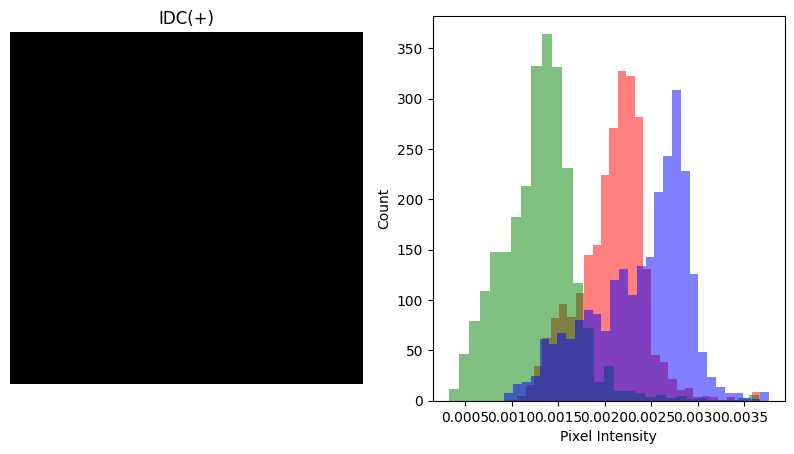

In [13]:
plotHistogram(X_train[100])

In [15]:
print(Y_test)

[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 

In [16]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainHot = to_categorical(Y_train, num_classes = 2)
Y_testHot = to_categorical(Y_test, num_classes = 2)

In [17]:
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

In [18]:
# Deal with imbalanced class sizes below
# Make Data 1D for compatability upsampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
#print("X_train Shape: ",X_train.shape)
#print("X_test Shape: ",X_test.shape)
#print("X_trainFlat Shape: ",X_trainFlat.shape)
#print("X_testFlat Shape: ",X_testFlat.shape)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
#ros = RandomOverSampler(ratio='auto')
ros = RandomUnderSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 2)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 2)
#print("X_train: ", X_train.shape)
#print("X_trainFlat: ", X_trainFlat.shape)
#print("X_trainRos Shape: ",X_trainRos.shape)
#print("X_testRos Shape: ",X_testRos.shape)
#print("Y_trainRosHot Shape: ",Y_trainRosHot.shape)
#print("Y_testRosHot Shape: ",Y_testRosHot.shape)

for i in range(len(X_trainRos)):
    height, width, channels = 50,50,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
#print("X_trainRos Shape: ",X_trainRos.shape)
#print("X_trainRosReshaped Shape: ",X_trainRosReshaped.shape)

for i in range(len(X_testRos)):
    height, width, channels = 50,50,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
#print("X_testRos Shape: ",X_testRos.shape)
#print("X_testRosReshaped Shape: ",X_testRosReshaped.shape)

dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)
print(dict_characters)

*Step 4: Define Helper Functions for the Classification Task*

In [19]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
print("Old Class Weights: ",class_weight)
from sklearn.utils import class_weight
class_weight2 = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
print("New Class Weights: ",class_weight2)

In [20]:
# Helper Functions  Learning Curves and Confusion Matrix

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

*Step 5: Evaluate Classification Models*

In a previous kernel I evaluated a number of different classification algorithms while using an abbreviated form of this same dataset.  To see how and why I chose the model that I use below, please see the following link: https://www.kaggle.com/paultimothymooney/predicting-idc-in-breast-cancer-histology-images/

In [21]:
def runKerasCNNAugment(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 128
    num_classes = 2
    epochs = 8
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs,class_weight=f, validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNNAugment(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

Next I will try one more time but without the undersampling step.

In [22]:
#runKerasCNNAugment(X_train, Y_trainHot, X_test, Y_testHot,2,class_weight)

90+% accuracy is pretty good!  And it does not look too be to overfit or too biased based off of the learning curve and confusion matrix.  In the future, I will improve the score by optimizing the data augmentation step as well as the network architecture.